# $\Delta E$

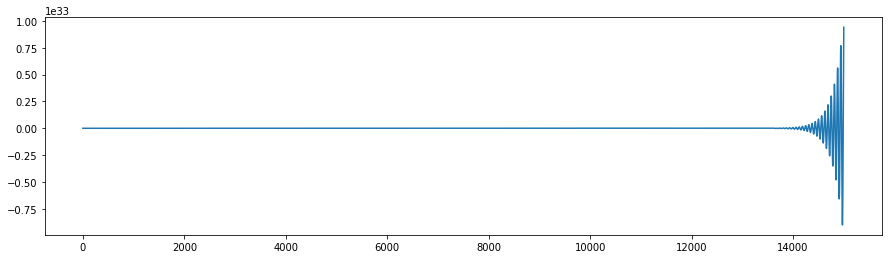

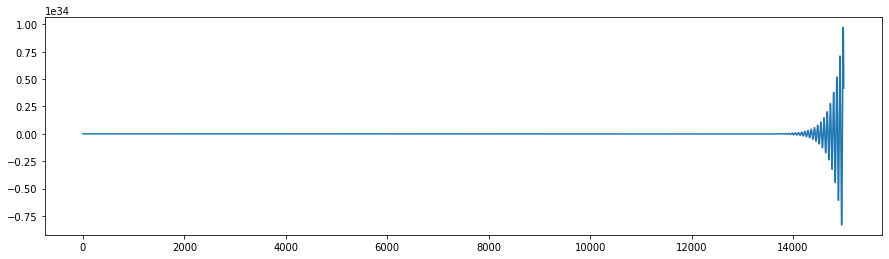

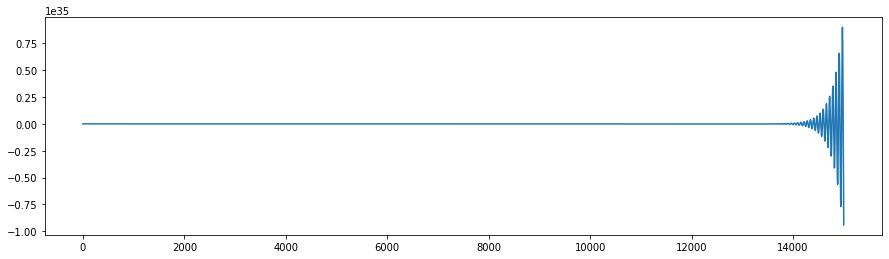

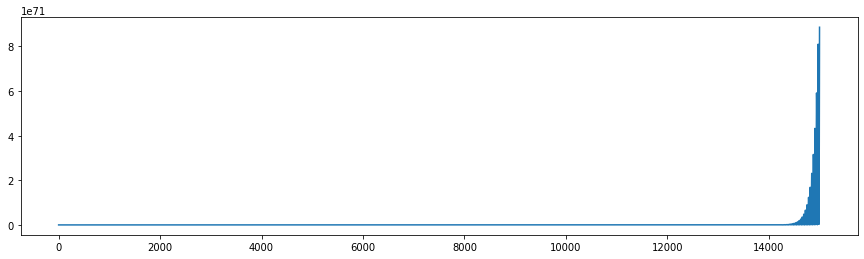

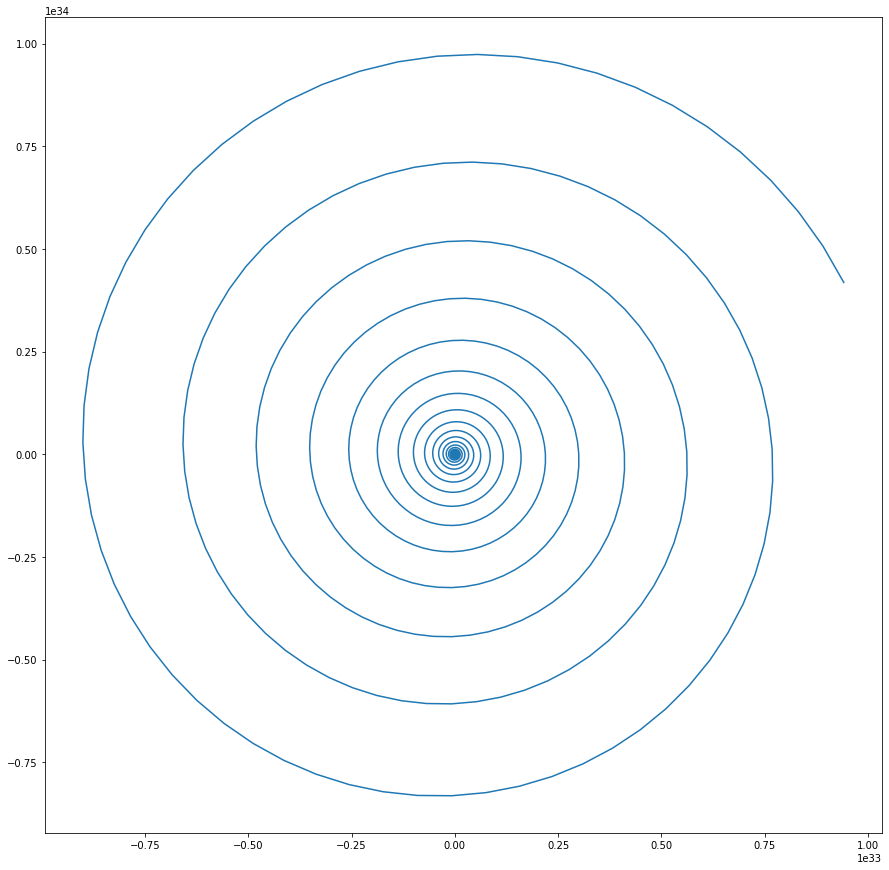

In [41]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import display, clear_output

def plot_1d(data):
    plt.figure(figsize=(15, 4))
    plt.plot(data)
    plt.show()

class Dyn_point_1D:
    def __init__(self, m = 1.0, x0 = 0.0, v0 = 0.0, dt = 0.01, A0 = np.array([[0, 1], [0, 0]])):
        self.m = m
        
        self.x = np.array([[x0], [v0]])
        self.dt = dt
        
        #state transition function
        self.A = A0
        
        #control -> xdot (matrix B from x_dot = Ax + Bu)
        self.B = np.array([[0], [1.0 / self.m]])
        
    def get_state(self):
        #print("state shape", self.x.shape)
        
        return self.x
    
    def sys_dyn(self, u):
        x_dot = np.zeros_like(self.x)
        
        x_dot = self.A @ self.x + self.B * u
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):
        #Euler
        self.x = self.x + sys_dyn * self.dt
        
        #Better Euler
        #YOUR CODE BELOW
        
        #YOUR CODE ABOVE
        
def run_episode(Q, R, x0 = 4.0, v0 = 2.0, A = np.array([[0.0, 1.0], [0.0, -0.01]])):
    dyn_point = Dyn_point_1D(x0 = x0, v0 = v0, A0 = A)

    iter_num = 15000
    i = 0

    x_traj = []
    v_traj = []
    u_traj = []

    while(True):
        #control = 1 * math.sin(i / 10.0)
        state = dyn_point.get_state()
        
        control = np.array([[- 100 * state[0, 0] - 0 * state[1, 0]]])

        x_dot = dyn_point.sys_dyn(control)
        dyn_point.integrate_sys_dyn(x_dot)

        x_traj.append(state[0, 0])
        v_traj.append(state[1, 0])
        u_traj.append(control[0, 0])

        i += 1

        if (i > iter_num):
            break
    
    return x_traj, v_traj, u_traj

def state_action_cost(x, u, Q, R):
    #print(x.shape, u.shape)
    
    cost = x.T @ Q @ x + u.T @ R @ u
    
    return cost

def episode_cost(x_hist, v_hist, u_hist, Q, R):
    total_cost = 0
    cost_hist = []
    
    for x, v, u in zip(x_hist, v_hist, u_hist):
        
        x_vec = np.array([x, v])
        u_vec = np.array([u])
                
        cost = state_action_cost(x_vec, u_vec, Q, R)
        
        total_cost += cost
        cost_hist.append(cost)
    
    return total_cost, cost_hist

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import display, clear_output

def run_and_plot_episode(q1, q2, q3, r):
    Q = np.array([[q1, q2],
                  [q2, q3]])

    R = np.array([[r]])
    
    x_hist, v_hist, u_hist = run_episode(Q, R, A = np.array([[0.0, 1.0], [0.0, 0.0]]))
    
    #print(v_hist)
    
    total_cost, cost_hist = episode_cost(x_hist, v_hist, u_hist, Q, R)

    #print(total_cost)

    plot_1d(x_hist)
    plot_1d(v_hist)
    plot_1d(u_hist)
    plot_1d(cost_hist)

    plt.figure(figsize=(15, 15))
    plt.plot(x_hist, v_hist)
    plt.show()
    clear_output(wait = True)

run_and_plot_episode(1, 0, 10, 100)

# Cart-pole

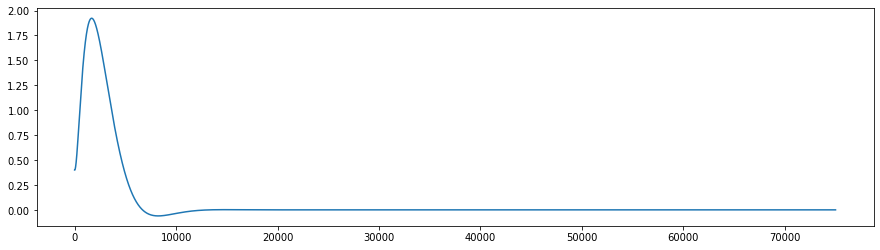

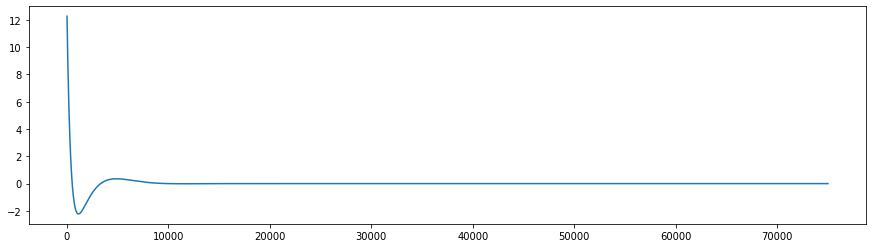

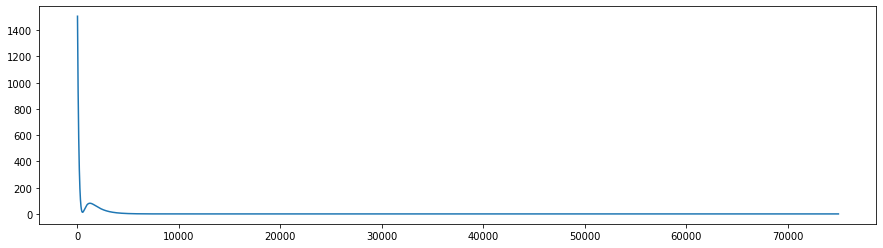

<Figure size 1080x1080 with 0 Axes>

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy import linalg

class Cart_pole:
    def __init__(self, M = 1.0, m = 1.0, l = 3.0, g = 10.0,
                 a0 = 0.2, ad0 = -0.3, x0 = 1.2, xd0 = -0.1,
                 dt = 0.001, Q = np.eye(4), R = np.eye(1)):
        self.M = M
        self.m = m
        self.l = l
        self.g = g
        
        self.x = np.array([[x0], [xd0], [a0], [ad0]])
        self.dt = dt
        
        #state transition function
        self.A = np.array\
        ([[0, 1, 0,                     0],
          [0, 0, m * g / M,             0],
          [0, 0, 0,                     1],
          [0, 0, (m + M) * g / (M * l), 0]])
        
        #control -> xdot (matrix B from x_dot = Ax + Bu)
        self.B = np.array([[0], [1.0 / M], [0], [1.0 / (M * l)]])
        
        self.Q = Q
        self.R = R
        
        self.P = linalg.solve_continuous_are(self.A, self.B, self.Q, self.R)
        self.K = np.linalg.inv(R) @ self.B.T @ self.P
        
    def get_state(self):
        return self.x
    
    def sys_dyn(self, u):
        x_dot = np.zeros_like(self.x)
        
        ax = self.A @ self.x
        bu = self.B * u
        
        x_dot = ax + bu
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):
        self.x = self.x + sys_dyn * self.dt
    
    def lqr_feedback(self, x):
        u = - self.K @ x
        
        return u

def state_action_cost(x, u, Q, R):
    #print(x.shape, u.shape)
    
    cost = x.T @ Q @ x + u.T @ R @ u
    
    return cost

def episode_cost(x_hist, u_hist, Q, R):
    total_cost = 0
    cost_hist = []
    
    for x, u in zip(x_hist, u_hist):
        cost = state_action_cost(x, u, Q, R)
        
        total_cost += cost
        cost_hist.append(cost)
    
    return total_cost, cost_hist

def run_cart_pole_episode(Q, R, a0 = 0.2, ad0 = -0.3, x0 = 1.2, xd0 = -0.1):
    dyn_point = Cart_pole(M = 1.0, m = 1.0, l = 3.0, g = 10.0,
                 a0 = a0, ad0 = ad0, x0 = x0, xd0 = xd0,
                 dt = 0.001, Q = Q, R = R)

    iter_num = 75000
    i = 0

    x_traj = []
    v_traj = []
    u_traj = []
    
    while(True):
        state = dyn_point.get_state()

        #control = np.array([[0]])
        control = dyn_point.lqr_feedback(state)

        x_dot = dyn_point.sys_dyn(control)
        
        #print("xdot: ", x_dot)
        
        dyn_point.integrate_sys_dyn(x_dot)
        
        x_traj.append(state)
        u_traj.append(control)

        i += 1

        if (i > iter_num):
            break
    
    return x_traj, u_traj

def run_and_plot_cart_pole_episode(interactive = False):
    Q = np.eye(4)
    Q[0, 0] *= 10
#     Q[1, 1] *= 0.1

    R = np.eye(1) * 10
    
    x_hist, u_hist = run_cart_pole_episode(Q, R, a0 = -0.2, ad0 = 0.0,
                                       x0 = 0.4, xd0 = -0.1)
        
    total_cost, cost_hist = episode_cost(x_hist, u_hist, Q, R)
    
    x_list = [x[0] for x in x_hist]
    plot_1d(x_list)

    
    u_hist_list = [el[0, 0] for el in u_hist]
    cost_hist_list = [el[0, 0] for el in cost_hist]
    
    plot_1d(u_hist_list)
    plot_1d(cost_hist_list)

    plt.figure(figsize=(15, 15))
    #plt.plot(x_hist, v_hist)
    plt.show()
    clear_output(wait = True)
    
    return x_hist, u_hist

x_hist, u_hist = run_and_plot_cart_pole_episode()

In [43]:
# def draw_pendulum(canvas, x, y, l, alpha, color = (123, 234, 234), inverted = False):
#     direction = 1
    
#     if (inverted == True):
#         direction = -1
    
#     endpoint = (int(x + l * np.cos(alpha + direction * np.pi / 2)),
#                 int(y + l * np.sin(alpha + direction * np.pi / 2)))
    
#     cv2.line(canvas, (x, y), endpoint, color, 5)
    
#     cv2.circle(canvas, endpoint, 25, (123, 23, 234), -1)

def draw_cart_pole(cx, cy, x, alpha, scale = 100, color = (234, 123, 123), canvas = None,
                   alpha_0 = 0):
    if (canvas is None):
        canvas = np.ones((700, 700, 3)) * 0
    
    h, w, _ = canvas.shape
    
    cv2.line(canvas, (0, h // 2), (w, h // 2), color, 2)
    
    cv2.circle(canvas, (w // 2, h // 2), 7, color, 2)
    
    cv2.rectangle(canvas, (int(cx - w // 20 + x * scale), cy - h // 40),
                          (int(cx + w // 20 + x * scale), cy + h // 40), color, -1)
    
    cv2.line(canvas, (int(cx + x * scale), cy),
                     (int(cx + x * scale - w / 5 * math.sin(alpha + alpha_0)),
                          cy - int(w / 5 * math.cos(alpha + alpha_0))), color, 2)
    
    cv2.circle(canvas, (int(cx + x * scale - w / 5 * math.sin(alpha + alpha_0)),
                          cy - int(w / 5 * math.cos(alpha + alpha_0))), 27, color, 7)
    
    return canvas

def animate_cart_pole_trajectory(x_traj):
    WIND_X = 700
    WIND_Y = 700
    
    canvas = np.ones((700, 700, 3), np.uint8) * 70
    
    i = 0
    
    while (True):        
        x = x_traj[i]
        i += 25
        
        if (i >= len(x_traj)):
            break
        
        canvas[:, :, :] = 70
             
        x_coord, _, alpha_coord, _ = x
        
        draw_cart_pole(WIND_X // 2, WIND_Y // 2, x_coord, alpha_coord, canvas = canvas)
        
        cv2.imshow("cart_pole", canvas)
        
        key = cv2.waitKey(10) & 0xFF
        
        if (key == ord('q')):
            break
    
    cv2.destroyAllWindows()
    cv2.waitKey(10)

animate_cart_pole_trajectory(x_hist)

# Khitry Cart-pole

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy import linalg
import copy

class Cart_pole:
    def __init__(self, M = 1.0, m = 1.0, l = 3.0, g = 10.0,
                 a0 = 0.2, ad0 = -0.3, x0 = 1.2, xd0 = -0.1,
                 dt = 0.001, Q = np.eye(4), R = np.eye(1),
                 WIND_X = 700, scale = 100, max_goal_pos = 3):
        self.M = M
        self.m = m
        self.l = l
        self.g = g
        
        self.x = np.array([[x0], [xd0], [a0], [ad0]])
        self.dt = dt
        
        #state transition function
        self.A = np.array\
        ([[0, 1, 0,                     0],
          [0, 0, m * g / M,             0],
          [0, 0, 0,                     1],
          [0, 0, (m + M) * g / (M * l), 0]])
        
        #control -> xdot (matrix B from x_dot = Ax + Bu)
        self.B = np.array([[0], [1.0 / M], [0], [1.0 / (M * l)]])
        
        self.Q = Q
        self.R = R
        
        self.P = linalg.solve_continuous_are(self.A, self.B, self.Q, self.R)
        self.K = np.linalg.inv(R) @ self.B.T @ self.P
        
        self.WIND_X = WIND_X
        self.scale = scale
        self.target_x = 0.0
        self.max_goal_pos = max_goal_pos
        
        cv2.namedWindow('cart_pole')
        cv2.createTrackbar("goal_position", "cart_pole", max_goal_pos,
                           max_goal_pos * 2,
                          lambda i : i)

    def get_state(self):
        return self.x
    
    def sys_dyn(self, u):
        x_dot = np.zeros_like(self.x)
        
        ax = self.A @ self.x
        bu = self.B * u
        
        x_dot = ax + bu
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):
        self.x = self.x + sys_dyn * self.dt
    
    def lqr_feedback(self, x):
        target = cv2.getTrackbarPos("goal_position", "cart_pole")
        
        #YOUR CODE BELOW
        
        u = - self.K @ x
        
        #YOUR CODE ABOVE
        
        return u

def state_action_cost(x, u, Q, R):
    #print(x.shape, u.shape)
    
    cost = x.T @ Q @ x + u.T @ R @ u
    
    return cost

def episode_cost(x_hist, u_hist, Q, R):
    total_cost = 0
    cost_hist = []
    
    for x, u in zip(x_hist, u_hist):
        cost = state_action_cost(x, u, Q, R)
        
        total_cost += cost
        cost_hist.append(cost)
    
    return total_cost, cost_hist

def run_cart_pole_episode(Q, R, a0 = 0.2, ad0 = -0.3, x0 = 1.2, xd0 = -0.1,
                          scale = 30, max_goal_pos = 10):
    WIND_X = 700
    WIND_Y = 700
    canvas = np.ones((700, 700, 3), np.uint8) * 70
    
    dyn_point = Cart_pole(M = 1.0, m = 1.0, l = 3.0, g = 10.0,
                 a0 = a0, ad0 = ad0, x0 = x0, xd0 = xd0,
                 dt = 0.1, Q = Q, R = R, WIND_X = WIND_X,
                 scale = scale, max_goal_pos = max_goal_pos)

    iter_num = 750000
    i = 0

    x_traj = []
    v_traj = []
    u_traj = []
    
    while(True):
        state = dyn_point.get_state()

        #control = np.array([[0]])
        control = dyn_point.lqr_feedback(state)

        x_dot = dyn_point.sys_dyn(control)
        
        #print("xdot: ", x_dot)
        
        dyn_point.integrate_sys_dyn(x_dot)
        
        x_traj.append(state)
        u_traj.append(control)
        
        canvas = cv2.addWeighted(canvas, 0.93, canvas, 0, 0)
        draw_cart_pole(WIND_X // 2, WIND_Y // 2, state[0], state[2],
                       canvas = canvas, scale = scale)

        cv2.imshow("cart_pole", canvas)
        
        i += 1

        if (i > iter_num):
            break
        
        key = cv2.waitKey(10) & 0xFF
        
        if (key == ord('q')):
            break
    
    cv2.destroyAllWindows()
    cv2.waitKey(10)
    
    return x_traj, u_traj

Q = np.eye(4)
Q[0, 0] *= 10
#Q[1, 1] *= 0.1
R = np.eye(1) * 1

x_hist, u_hist = run_cart_pole_episode(Q, R, a0 = -0.2, ad0 = 0.0,
                x0 = 0.4, xd0 = -0.1, max_goal_pos = 10)

# Inverted pendulum with insufficient torque

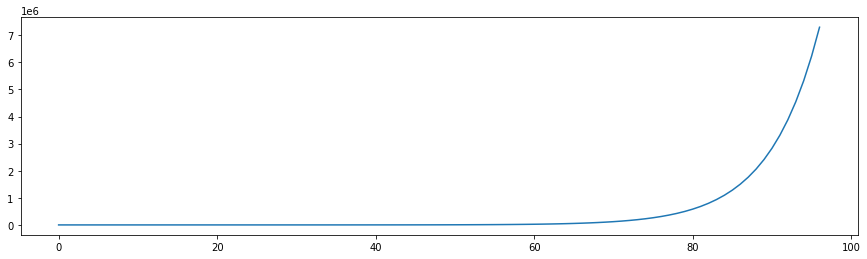

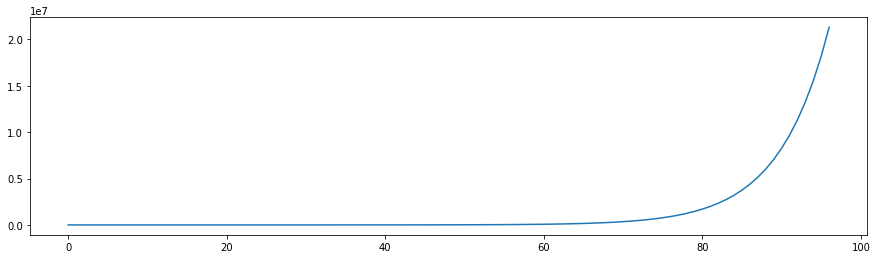

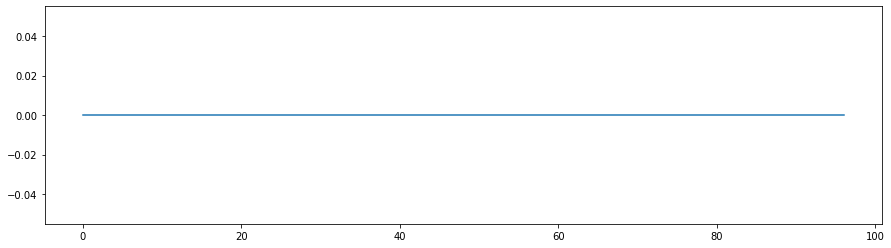

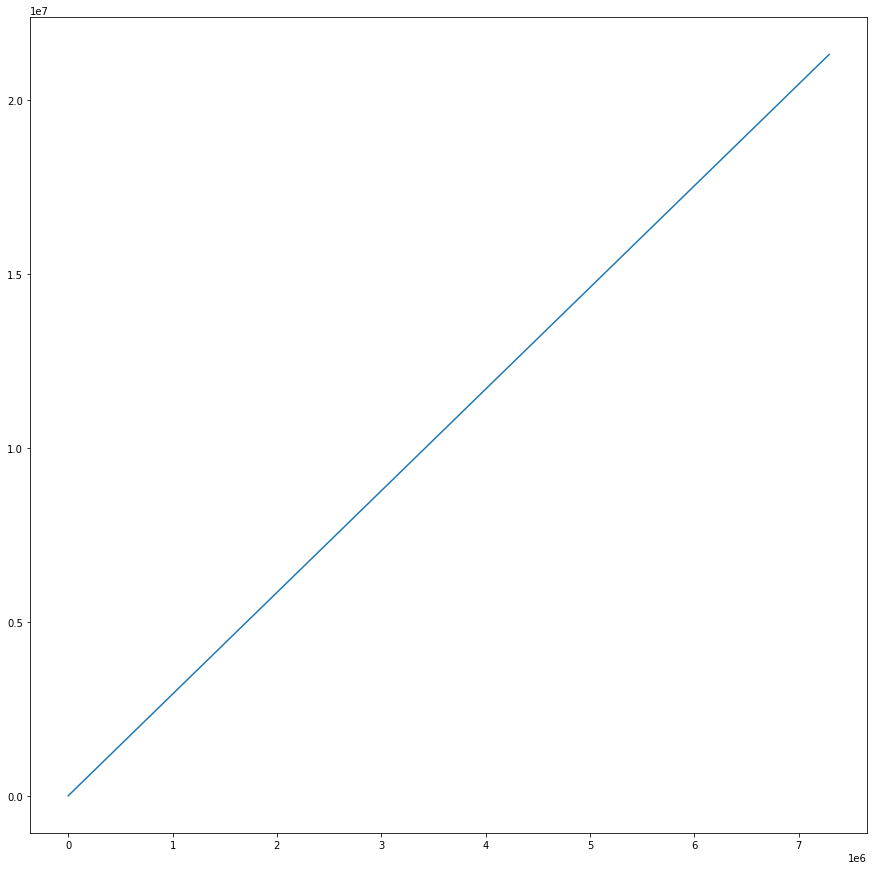

In [45]:
class Weak_inverted_pendulum:
    def __init__(self, m = 1.0, l = 1.0, g = 10.0, x0 = 3, v0 = 0.0, dt = 0.05,
                 A0 = np.array([[0, 1],
                                [0, 0]]),
                 max_tau = 3):
        self.m = m
        self.l = l
        self.g = g
        self.max_tau = max_tau
        
        self.x = np.array([[x0], [v0]])
        self.dt = dt
        
        #state transition function
        self.A = A0
        self.A[1, 0] = self.g / self.l
        
        #control -> xdot (matrix B from x_dot = Ax + Bu)
        self.B = np.array([[0], [1.0 / (self.m * self.l**2)]])
        
    def get_state(self):
        #print("state shape", self.x.shape)
        
        return self.x
    
    def sys_dyn(self, u):
        x_dot = np.zeros_like(self.x)
        
        u_effective = np.clip(u, -self.max_tau, self.max_tau)

        #YOUR CODE BELOW
        
        x_dot = self.A @ self.x + self.B * u_effective
                
        #YOUR CODE ABOVE
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):
        #self.x = self.x + sys_dyn * self.dt
        
        self.x[1] += sys_dyn[1] * self.dt
        self.x[0] += self.x[1] * self.dt

def draw_pendulum(canvas, x, y, l, alpha, color = (123, 234, 234),
                  inverted = False):
    direction = 1
    
    if (inverted == True):
        direction = -1
    
    endpoint = (int(x - l * np.cos(alpha + direction * np.pi / 2)),
                int(y + l * np.sin(alpha + direction * np.pi / 2)))
    
    cv2.line(canvas, (x, y), endpoint, (123, 234, 234), 5)
    
    cv2.circle(canvas, endpoint, 25, color, -1)

def swing_up_feedback(x, max_tau = 5):
    #YOUR CODE BELOW

    
    #YOUR CODE ABOVE

    return u

def pendulum_energy(x, v, m = 1, l = 1, g = 10):
    #YOUR CODE BELOW
    
    #YOUR CODE BELOW
    
    return E

def energy_based_feedback(x, E = pendulum_energy, max_tau = 5):
    #YOUR CODE BELOW
    
    #YOUR CODE ABOVE

    return u

def run_pendulum_episode(iter_num = 1000, visualize = True):
    if (visualize == True):
        WIND_X = 700
        WIND_Y = 700
        canvas = np.ones((700, 700, 3), np.uint8) * 70
    
    pendulum = Weak_inverted_pendulum(x0 = 3)

    i = 0

    x_traj = []
    v_traj = []
    u_traj = []
    
    while(True):
        state = pendulum.get_state()

        control = 0 #swing_up_feedback(state, pendulum.max_tau)
        #control = energy_based_feedback(state)
        
        x_dot = pendulum.sys_dyn(control)
                
        pendulum.integrate_sys_dyn(x_dot)
        
        x_traj.append(state[0, 0])
        v_traj.append(state[1, 0])
        u_traj.append(control)
        
        i += 1

        if (i > iter_num):
            break

        if (visualize == True):
            canvas = cv2.addWeighted(canvas, 0.93, canvas, 0, 0)

            draw_pendulum(canvas, WIND_X // 2, WIND_Y // 2, 300,
                          state[0], (123, 234, 45), inverted = True)

            cv2.imshow("pendulum", canvas)

            key = cv2.waitKey(10) & 0xFF

            if (key == ord('q')):
                break
    
    if (visualize == True):
        cv2.destroyAllWindows()
        cv2.waitKey(10)
    
    return x_traj, v_traj, u_traj

x_hist, v_hist, u_hist = run_pendulum_episode(visualize = True)

plot_1d(x_hist)
plot_1d(v_hist)
plot_1d(u_hist)

plt.figure(figsize=(15, 15))
plt.plot(x_hist, v_hist)
plt.show()
clear_output(wait = True)

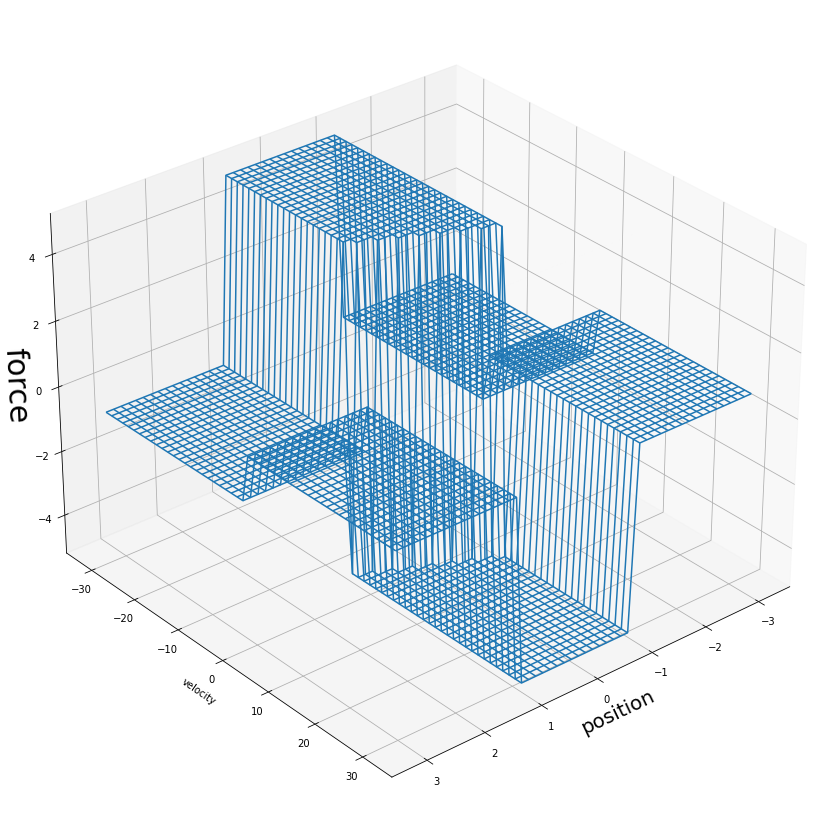

In [35]:
def visualize_function_3D(function, llim1, hlim1, a1name,
                          llim2, hlim2, a2name, pnum):
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111, projection='3d')

    X = np.linspace(llim1, hlim1, num = pnum)
    Y = np.linspace(llim2, hlim2, num = pnum)

    X, Y = np.meshgrid(X, Y)

    Z = X**2 + Y**2
    
    for i in range(len(X)):
        for j in range(len(X[0])):
            x = X[i, j]
            y = Y[i, j]

            #print("x, y", (x, y))
            
            t = function(np.array([[x], [y]]))
            
            #t = np.clip(t, -30, 30)
            
            Z[i, j] = t
    
    ax.view_init(30, 50)
    ax.plot_wireframe(X, Y, Z)

    ax.set_xlabel(a1name, fontsize=20, rotation=150)
    ax.set_ylabel(a2name)
    ax.set_zlabel(r'force', fontsize=30, rotation=60)
        
    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    #return data

feedbacks = [swing_up_feedback]#, energy_based_feedback]

for feedback in feedbacks:
    visualize_function_3D(feedback, -math.pi, math.pi,
        "position", -5 * math.pi * 2, 5 * math.pi * 2, "velocity", 50)